# Time Forecasting


### Load the data

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [51]:
df = pd.read_csv('data/sales_invoiced_lines_basics_cleaned_clustered.csv')
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

In [52]:
unique_products = df["ItemNo2"].unique()

#### THIS IS FOR SIMULATING A DF WITH THE UNIQUE ITEMS AND A CLUSTER FOR EACH. THIS IS TEMPORARY AND MUST BE CHANGED WITH THE DATA FOUND FROM THE CLUSTER ANALYSIS

In [53]:
# Simulate randoming clustering for each product
random_clusters = np.random.randint(0, 5, len(unique_products))
clustering_df = pd.DataFrame(columns=["ItemNo2", "Cluster"])
clustering_df["ItemNo2"] = unique_products
clustering_df["Cluster"] = random_clusters

In [54]:
cluster_type = 'KMeans' # Assuming that df has a column with the KMeans cluster numbers

In [55]:
df_frequency = "7D" # 1 Week
testing_period = 8 # 8 weeks
df_quantity_item = df.groupby(["ItemNo2", pd.Grouper(key='Date', freq=df_frequency)])["Quantity"].sum().reset_index() # Product grouping by unique products and quantity
df_quantity_item_cluster = df_quantity_item.merge(clustering_df, on="ItemNo2", how="left").set_index("Date") # Merging the cluster number to the product dataframe

### Create a cluster based time analysis


Cluster Time Analysis For Frequency 7D
Cluster 0: Seasonality is 0, Trend is 0, Volatility is 1
Cluster 1: Seasonality is 0, Trend is 0, Volatility is 1
Cluster 2: Seasonality is 0, Trend is 0, Volatility is 1
Cluster 3: Seasonality is 0, Trend is 1, Volatility is 1
Cluster 4: Seasonality is 0, Trend is 0, Volatility is 1


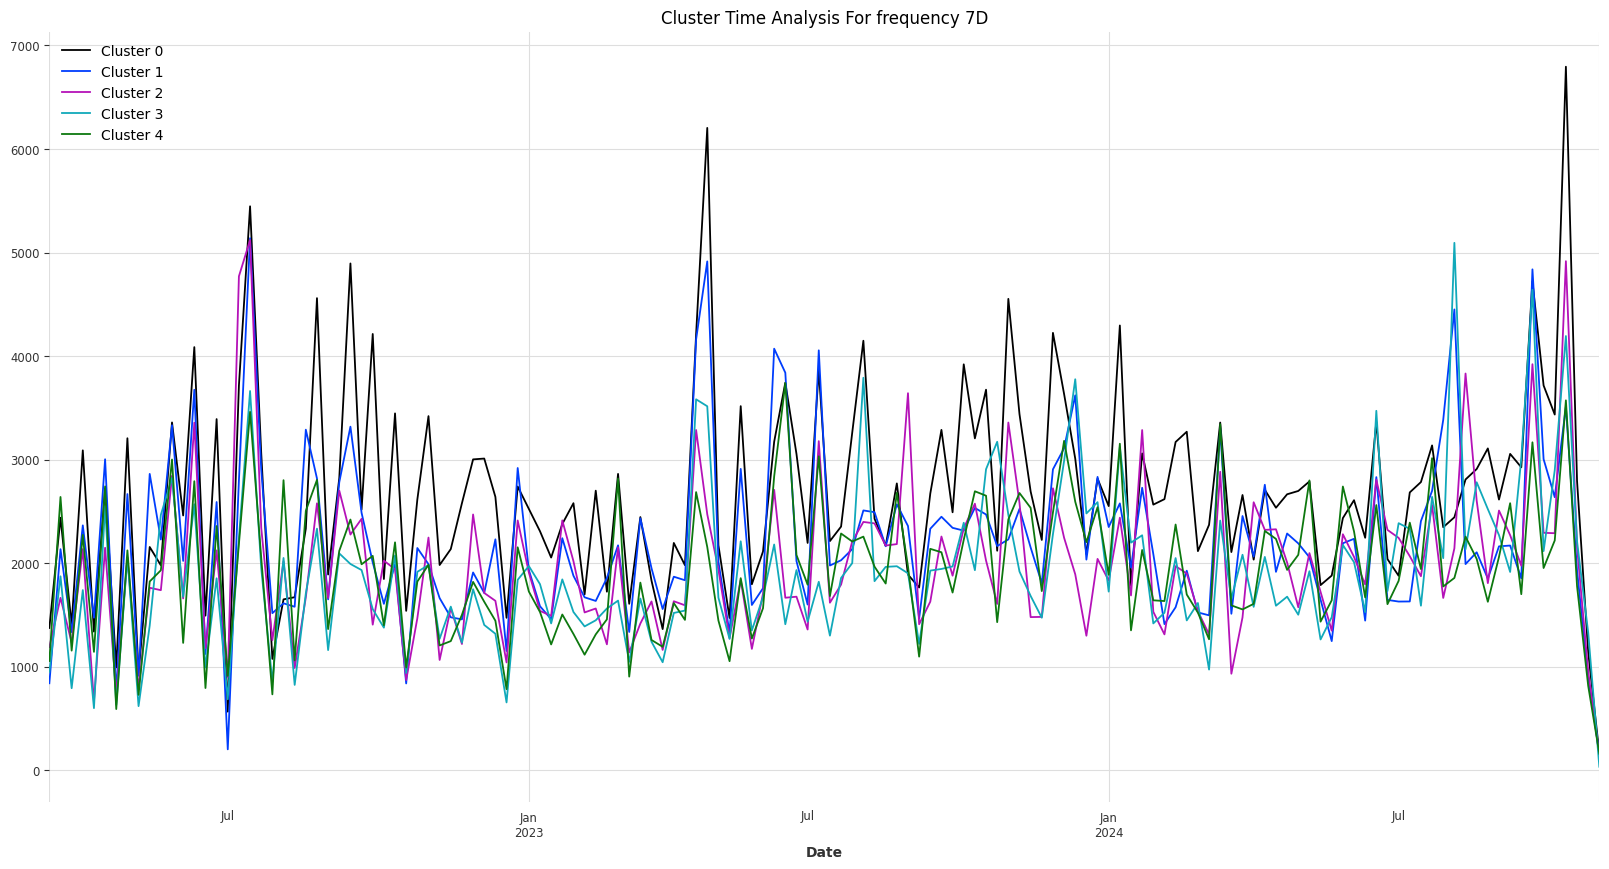

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_cluster_data = {} # Dictionary to store weekly sales data for each cluster
cluster_time_analysis = {} # Dictionary to store time series factors for each cluster

plt.figure(figsize=(20, 10))
print(f'\nCluster Time Analysis For Frequency {df_frequency}')
for cluster in sorted(clustering_df["Cluster"].unique()):
    # Group data by cluster and sum quantities by date
    weekly_sales_by_cluster = df_quantity_item_cluster[df_quantity_item_cluster["Cluster"] == cluster].groupby("Date")["Quantity"].sum()
    weekly_cluster_data[cluster] = weekly_sales_by_cluster
    weekly_sales_by_cluster.plot(label=f'Cluster {cluster}')
    
    # Decompose the time series to analyze seasonality, trend, and residuals
    result = seasonal_decompose(weekly_sales_by_cluster, model='additive', period=7)
    
    # Calculate the strength of seasonality, trend, and residuals
    seasonality_strength = result.seasonal.std() / weekly_sales_by_cluster.std()
    trend_strength = result.trend.dropna().std() / weekly_sales_by_cluster.std()
    residual_strength = result.resid.dropna().std() / weekly_sales_by_cluster.std()
    
    # Determine the level of seasonality, trend, and volatility
    seasonality = 1 if seasonality_strength > 0.5 else 0
    trend = 1 if trend_strength > 0.5 else 0                        # Can add more time series anylysis here
    volatility = 1 if residual_strength > 0.5 else 0


    print(f'Cluster {cluster}: Seasonality is {seasonality}, Trend is {trend}, Volatility is {volatility}')

    # Group clusters with similar seasonality, trend, and volatility
    key = f"s:{seasonality}, t:{trend}, v:{volatility}"
    if key not in cluster_time_analysis:
        cluster_time_analysis[key] = []
    cluster_time_analysis[key].append(cluster)

# Plot the cluster time analysis
plt.title(f'Cluster Time Analysis For frequency {df_frequency}')
plt.legend()
plt.show()
    

These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.

In [57]:
print("Dictionary showing the clusters with the same seasonality, trend and volatility")
print(cluster_time_analysis)


Dictionary showing the clusters with the same seasonality, trend and volatility
{'s:0, t:0, v:1': [0, 1, 2, 4], 's:0, t:1, v:1': [3]}


Simple Clusters (low seasonality): Use ARIMA.

Complex Seasonality: Use Prophet.

Highly Non-linear Clusters: Consider LSTM or other deep learning methods.

Small Data Clusters: If clusters have limited data, use simpler models like Exponential Smoothing or SARIMA.

### Using DARTS Library with different models 

In [95]:
from darts.metrics import smape
# import scaler from sklearn
from sklearn.preprocessing import MinMaxScaler


def plot_predictions(training, test, preds, error, cluster,  model_name):
    '''
    Plot the training, test and forecasted values.
    Args:
        training: TimeSeries of training values
        test: TimeSeries of test values
        preds: TimeSeries of predicted values
        model_name: Title for the plot
    '''
    plt.figure(figsize=(8, 5))
    training[-100:].plot(label='training')
    test.plot(label='actual', color='orange', alpha=0.5)
    preds.plot(label='forecast', lw=2, color='green', alpha=0.5)
    plt.title(f'Cluster {cluster} - {model_name}: SMAPE: {error:.2f}%')
    plt.legend()
    plt.show()

def prepare_data(weekly_cluster_data, cluster, scaling = False):
    '''
    Prepare the data for training the model.
    Args:
        weekly_cluster_data: Dictionary of weekly sales data for each cluster
        cluster: Cluster number
    Returns:
        training: TimeSeries of training values
        test: TimeSeries of test values
    '''
    
    if scaling:
        scaler = MinMaxScaler()
        weekly_cluster_data[cluster] = scaler.fit_transform(weekly_cluster_data[cluster]) # Normalize the data


    training_series = TimeSeries.from_series(weekly_cluster_data[cluster]) # Convert to timeseries
    training_series[:-1] # Remove the last value to avoid using a week thats not complete
    training = training_series[:-testing_period]    # Train, test data split for training
    test = training_series[-testing_period:]    

    return training_series, training, test

In [59]:
from darts.models import ExponentialSmoothing, ARIMA, AutoARIMA
from darts import TimeSeries

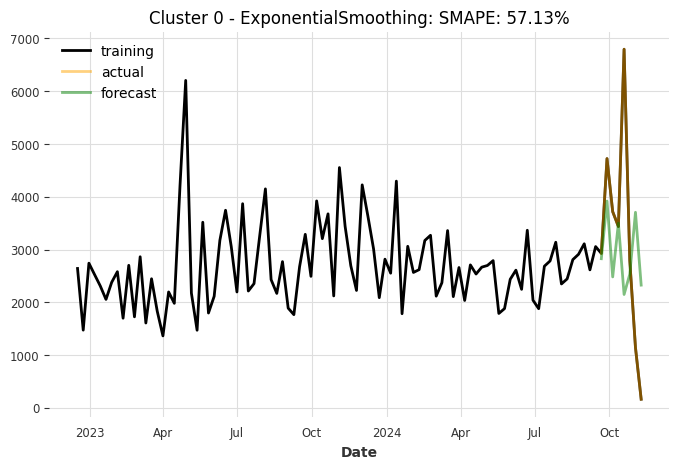

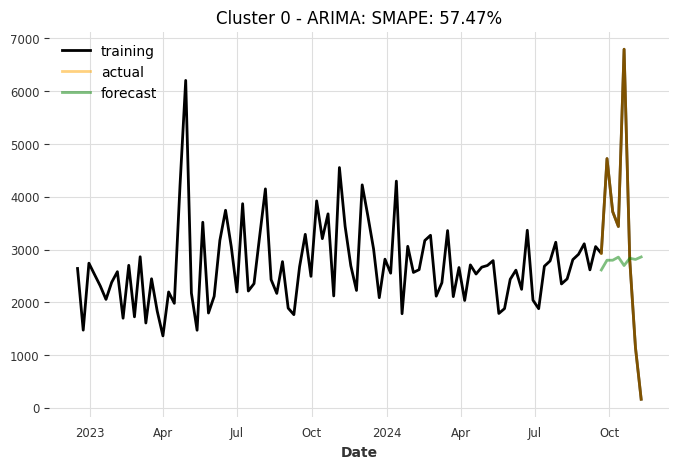

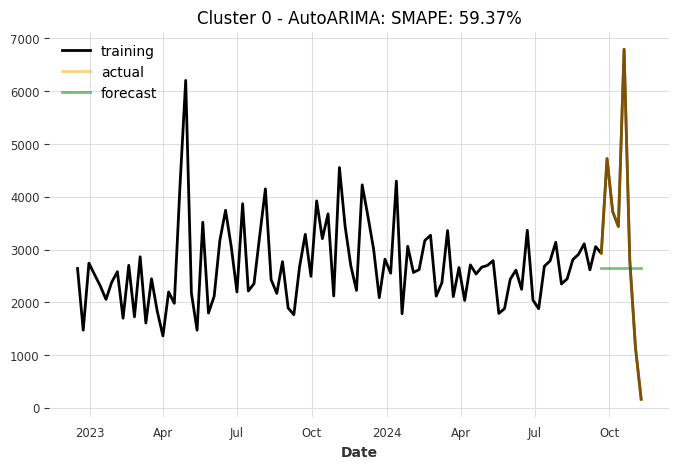

In [96]:
def forecast_baselines(model, cluster, model_name):

    training_series, training, test = prepare_data(weekly_cluster_data, cluster, scaling = False) # Prepare the data
    model.fit(training) # Fit the model

    forecast = model.predict(len(test)) # Forecast same amount of data as test
    error = smape(test, forecast) # Calculate the error
    plot_predictions(training_series, test, forecast, error,cluster , model_name) # Plot the results

    
forecast_baselines(ExponentialSmoothing(), 0, "ExponentialSmoothing")
forecast_baselines(ARIMA(), 0, "ARIMA")
forecast_baselines(AutoARIMA(), 0, "AutoARIMA")

In [61]:
from mango import Tuner
from darts.models import XGBModel
from scipy.stats import uniform
def forecast_with_optimizer(model, cluster, model_name, param_space, optimizer_config):
    '''
    Forecast with hyperparameter optimization.

    Args:
        model: String name of the model class
        cluster: Cluster number
        model_name: Name of the model
        param_space: Hyperparameter space to search. This is a dictionary with the hyperparameter name as the key and the search space as the value.
        optimizer_config: Configuration for the optimizer. Dictionary with the following:
            - initial_random: Number of random configurations to try
            - num_iteration: Number of iterations to run the optimizer
    '''
    # Define the objective function for the optimizer
    def objective_function(args_list):
        results = []
        for params in args_list:
            try:
                model_instance = eval(f"{model}(**params)")
                model_instance.fit(training)
                forecast = model_instance.predict(len(test))
                error = smape(test, forecast) 
                results.append(error)
            except Exception as e:
                print(f'Exception: {e}')
                results.append(100000000)  # Assign a high error value for exceptions
        return results

    training_series = TimeSeries.from_series(weekly_cluster_data[cluster]) # Convert to timeseries

    training = training_series[:-testing_period]    # Train, test data split for training
    test = training_series[-testing_period:]        # Train, test data split for testing

    tuner = Tuner(param_space, objective_function, optimizer_config)
    results = tuner.minimize()

    print('Best parameters:', results['best_params'])
    print('Best loss:', results['best_objective'])

    # Train and predict with the best parameters
    best_params = results['best_params']
    best_model = eval(f"{model}(**best_params)")
    best_model.fit(training)
    best_forecast = best_model.predict(len(test))

    best_error = smape(test, best_forecast)
    plot_predictions(training_series, test, best_forecast, best_error, cluster, model_name)


Best score: 55.47686700903787: 100%|██████████| 25/25 [01:03<00:00,  2.52s/it] 


Best parameters: {'lags': 14, 'learning_rate': 0.125154574348705, 'max_depth': 5, 'n_estimators': 222, 'output_chunk_length': 1}
Best loss: 55.47686700903787


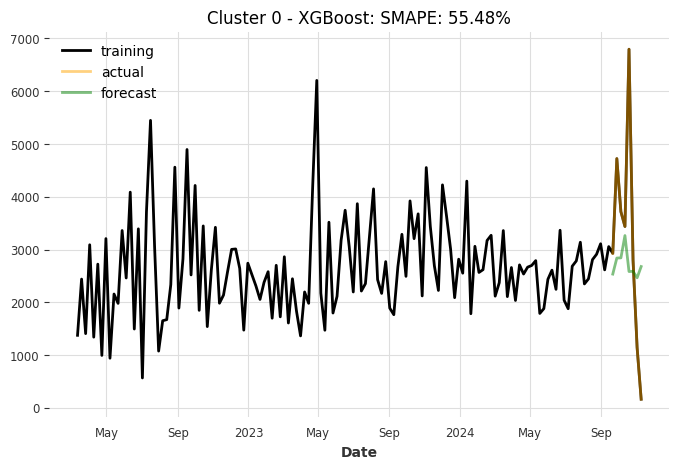

In [ ]:
# Use the optimizer to find the best hyperparameters for the XGBoost model
# Check the documentation for the model to what hyperparameters are available
forecast_with_optimizer(model = "XGBModel", cluster = 0, model_name= "XGBoost", param_space = {
    'lags': range(1, 25),
    'output_chunk_length': range(1, 25),
    'n_estimators': range(50, 500),
    'max_depth': range(1, 10),
    'learning_rate': uniform(0.01, 0.3)
    },
    optimizer_config = {
    'initial_random': 10,
    'num_iteration': 5
    }
)

Best score: 54.652280502574094: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


Best parameters: {'d': 2, 'p': 3, 'q': 1}
Best loss: 54.652280502574094


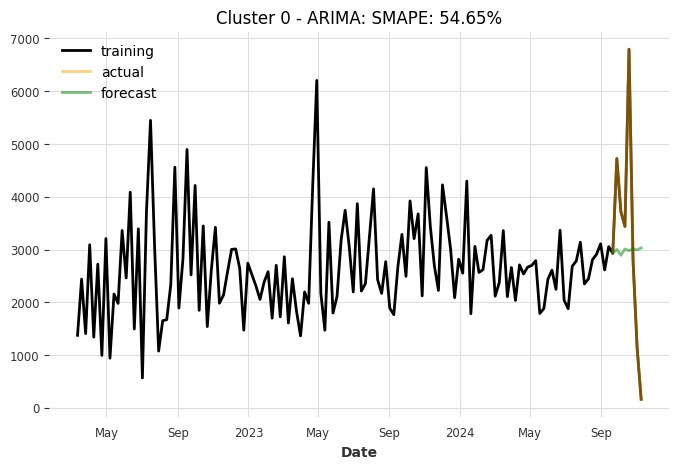

In [63]:
import warnings
warnings.filterwarnings('ignore')

# Use the optimizer to find the best hyperparameters for the ARIMA model
# Check the documentation for the model to see what hyperparameters are available
from darts.models import ARIMA
forecast_with_optimizer(model="ARIMA", cluster=0, model_name="ARIMA", param_space={
    'p': range(1, 10),
    'd': range(0, 3),
    'q': range(1, 10)
    },
    optimizer_config={
    'initial_random': 10,
    'num_iteration': 50
    }
)